In [ ]:
# This notebook is good for LUX tutorials (no PINNS)

# ["Lux", "NeuralPDE", "Zygote", "ModelingToolkit", "OrdinaryDiffEq", "LineSearches", "ProgressMeter", "Gnuplot", "Optimization", "OptimizationOptimJL", "OptimizationOptimisers"]
using Lux, NeuralPDE, Zygote
using ModelingToolkit
using ModelingToolkit: Interval
using OrdinaryDiffEq
using LineSearches
using MLDatasets, MLUtils, OneHotArrays
using ProgressMeter
using Gnuplot
#gpexec("load '~/gpconfig.cfg'")
import Base.show # this is needed otherwise the next line just defines a new function in a new module
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")
Gnuplot.options.verbose = false;
dump(Gnuplot.options) # print out the options

# https://julialang.slack.com/archives/C690QRAA3/p1711534935292689
# What is the relationship between Optimization.jl and Optimisers.jl?
# Optimization.jl is an interface over a whole set of optimization packages. It's the level of DifferentialEquations.jl, NonlinearSolve.jl, LinearSolve.jl, interfacing to tons (>10?) optimization packages.
# Optimisers.jl is a specific library of optimizers. Optimisers.jl is a specific library of optimizers.
# Optimization.jl has a wrapper for using Optimisers.jl methods (OptimizationOptimisers.jl), and that's the most common way things are trained with SciML applications like Neural ODEs.
# Optim.jl (OptimizationOptimJL.jl) is another Julia package implementing various algorithms to perform univariate and multivariate optimization
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Random, Statistics, ComponentArrays
# NN generator https://alexlenail.me/NN-SVG/

Gnuplot.Options
  dry: Bool false
  cmd: String "gnuplot"
  default: Symbol default
  term: String "qt 0 font \"Sans,9\""
  gpviewer: Bool false
  init: Array{String}((0,))
  verbose: Bool false
  preferred_format: Symbol auto


In [109]:
# Learning Lux from tutorial https://lux.csail.mit.edu/dev/tutorials/beginner/1_Basics#Gradients
# Let's consider linear regression y = Wx + b
# This model is a simple neural network with no hidden layers and an identity activation function 
# i.e., it's just linear regression. 
model = Dense(10 => 5)  # x is R^10, y is R^5 
rng = Random.default_rng()
Random.seed!(rng, 0)
ps, st = Lux.setup(rng, model)
#ps = ps |> ComponentArray # why do we need this?

# set up ground truth
n_samples = 50
x_dim = 10
y_dim = 5
W = randn(rng, Float32, y_dim, x_dim) # we want the NN weights and biases to be close to these values (since this is just linear regression so weights of model = weights of NN)
b = randn(rng, Float32, y_dim)
x_samples = randn(rng, Float32, x_dim, n_samples)
y_truth = W * x_samples .+ b
y_samples = W * x_samples .+ b .+ 0.01f0 .* randn(rng, Float32, y_dim, n_samples) # add some noise to the y samples
println("x shape: ", size(x_samples), "; y shape: ", size(y_samples))

# a basic mse to calculate the error in the ground truth from the initialized parameters
println("Initial loss Value with ground true parameters: ", sum(abs2, y_truth .- y_samples))

# set up the optimizer to use stochastic gradient descent
opt = Optimisers.Descent(0.01f0) # learning rate is 0.01
opt_state = Optimisers.setup(opt, ps) # initialize the state -- I don't know what this is doing.
println("opt_state: ", opt_state)

# define a loss function
function mse(model, ps, st, X, y)
    y_pred, st_new = model(X, ps, st)
    return sum(abs2, y_pred .- y), st_new
end
loss_function(ps, X, y) = mse(model, ps, st, X, y)

# run a single epoch  
# the pullback function evaluates the loss function with the given inputs (the loss function itself returns a tuple)
# but also returns a function that can be used to (left) multiply a vector and jacobian (i.e., the vjp)
# gradient() is really just syntactic sugar around the more fundamental function pullback.
# In other words, the VJP is the jacobian if the left vector is just ones -- returns the corresponding column of the jacobian
(loss, st), pb_f = Zygote.pullback(loss_function, ps, x_samples, y_samples) 
println("loss (initial epoch): ", loss) # would be large because NN weights/biases are far off 
println("state of the NN: ", st) 

# use the pullback function to get the gradient 
# not sure why a tuple (one(loss), nothing) is required as an input to the pullback function
# so this evaluates the derivative of the loss function at the x_samples and y_samples
gs = pb_f((one(loss), nothing))[1] 

# Update model parameters
# `Optimisers.update` can be used if mutation is not desired
opt_state, ps = Optimisers.update!(opt_state, ps, gs)
println("loss (after 1 epoc): ", loss_function(ps, x_samples, y_samples)[1]) # would be large because NN weights/biases are far off 
println("running 1000 epochs")
# # run 100 epochs
@showprogress dt=1 desc="Computing..." for i in 1:1000
    # In actual code, don't use globals. But here I will simply for the sake of demonstration
    global ps, st, opt_state 
    # Compute the gradient using the pullback API to update the states
    # the pullback evaluates the loss-function at the specified points (the first returned tuple)
    # the second tuple is the pullback function 
    (loss, st), pb_f = Zygote.pullback(loss_function, ps, x_samples, y_samples)
    # We pass nothing as the seed for `st`, since we don't want to propagate any gradient
    # for st
    gs = pb_f((one(loss), nothing))[1]
    # Update model parameters
    # `Optimisers.update` can be used if mutation is not desired
    opt_state, ps = Optimisers.update!(opt_state, ps, gs)
    # (i % 10 == 1 || i == 100) && println(lazy"Loss Value after $i iterations: $loss")
    sleep(0.001) # force the progress bar
end

# let's see how well the model has learned the ground truth
y_trainedmodel = model(x_samples, ps, st)[1]
println("Total Loss Value after training: ", sum(abs2, y_trainedmodel .- y_samples))

x shape: (10, 50); y shape: (5, 50)
Loss Value with ground true parameters: 0.02508387
opt_state: (weight = Leaf(Descent(0.01), nothing), bias = Leaf(Descent(0.01), nothing))
loss (initial epoch): 1999.7931
state of the NN: NamedTuple()
loss (after 1 epoc): 503.6789
running 1000 epochs


Computing... 100%|███████████████████████████████████████| Time: 0:00:02


Total Loss Value after training: 0.018524375


Chain(
    layer_1 = Dense(1 => 16, relu),     # 32 parameters
    layer_2 = Dense(16 => 1),           # 17 parameters
)         # Total: 49 parameters,
          #        plus 0 states.

size of x: (1, 128); size of y: (1, 128)


Computing... 100%|███████████████████████████████████████| Time: 0:00:00


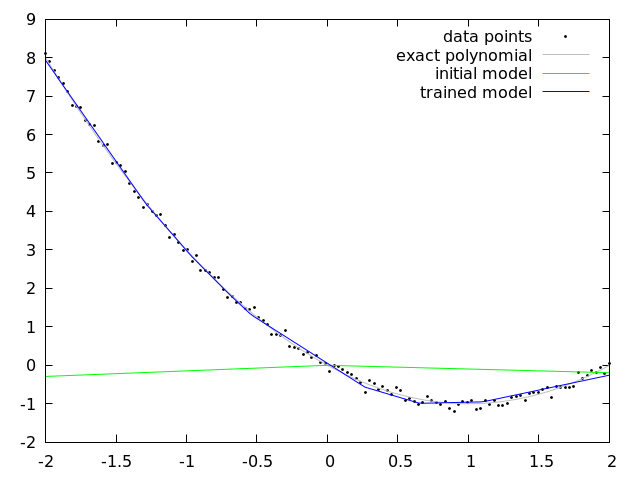

In [155]:
# Let's use Lux to fit to a polynomial y = x² - 2x
# generate 128 datapoints 
function generate_data(rng::AbstractRNG)
    x = reshape(collect(range(-2.0f0, 2.0f0, 128)), (1, 128))
    y = evalpoly.(x, ((0, -2, 1),)) .+ randn(rng, (1, 128)) .* 0.1f0 # add noise to the data
    return (x, y)
end
rng = MersenneTwister()
Random.seed!(rng, 12345)
(x, y) = generate_data(rng)
println("size of x: ", size(x), "; size of y: ", size(y))

model = Chain(Dense(1 => 16, relu), Dense(16 => 1)) # a single layer, 16 neurons, relu by default
display(model) # will print some model details

# we need to set up an optimiser to minimize the cost function of the NN 
opt = OptimizationOptimisers.Adam(0.03f0)

# define the loss function -- we'll be using Lux.Training API for this 
# so we need to ensure that our loss function takes 4 inputs – model, parameters, states and data. 
# the function must return 3 values – loss, updated_state, and any computed statistics.
function loss_function(model, ps, st, data)
    y_pred, st = Lux.apply(model, data[1], ps, st)
    mse_loss = mean(abs2, y_pred .- data[2])
    return mse_loss, st, ()
end

# Let's create a TrainState: https://lux.csail.mit.edu/dev/api/Lux/contrib#Lux.Experimental.TrainState
# In the previous example, we used the vjp manually to get the derivative
# and then updated the optimiser -- in this example, we are just using wrappers 
tstate = Lux.Experimental.TrainState(rng, model, opt)
vjp_rule = AutoZygote() # (From Optimisers.jl) what does this mean An AbstractADType choice for use in OptimizationFunction for automatically generating the unspecified derivative functions.

# apply the model 
y_pred_init = Lux.apply(tstate.model, x, tstate.parameters, tstate.states)[1] # returns a tuple of values and model state


function training_loop(tstate::Lux.Experimental.TrainState, vjp, data, epochs)
    @showprogress dt=0.1 desc="Computing..." for epoch in 1:epochs
        grads, loss, stats, tstate = Lux.Training.compute_gradients(
            vjp, loss_function, data, tstate)
        # if epoch % 50 == 1 || epoch == epochs
        #     @printf "Epoch: %3d \t Loss: %.5g\n" epoch loss
        # end
        tstate = Lux.Training.apply_gradients(tstate, grads)
    end
    return tstate
end
tstate = training_loop(tstate, vjp_rule, (x, y), 250)
y_pred_trained = Lux.apply(tstate.model, x, tstate.parameters, tstate.states)[1] # returns a tuple of values and model state
@gp "reset" 
@gp :- x y "with points title 'data points' pt 7 ps 0.3 lc 'black'"
@gp :- x evalpoly.(x, ((0, -2, 1),)) "with lines title 'exact polynomial' lw 1 lc 'gray'"
@gp :- x y_pred_init "with lines title 'initial model' lw 1 lc 'green'"
@gp :- x y_pred_trained "with lines title 'trained model' lw 1 lc 'blue'"


opt_state: (layer_1 = (weight = Leaf(Descent(0.05), nothing), bias = Leaf(Descent(0.05), nothing)), layer_2 = (weight = Leaf(Descent(0.05), nothing), bias = Leaf(Descent(0.05), nothing)))
loss (initial epoch): 9.437287494641955
state of the NN: (layer_1 = NamedTuple(), layer_2 = NamedTuple())
loss (after 1 epoc): 6.381217346716226
running 1000 epochs


Computing... 100%|███████████████████████████████████████| Time: 0:00:00


loss (after 1000 epochs): 0.015949974360926423


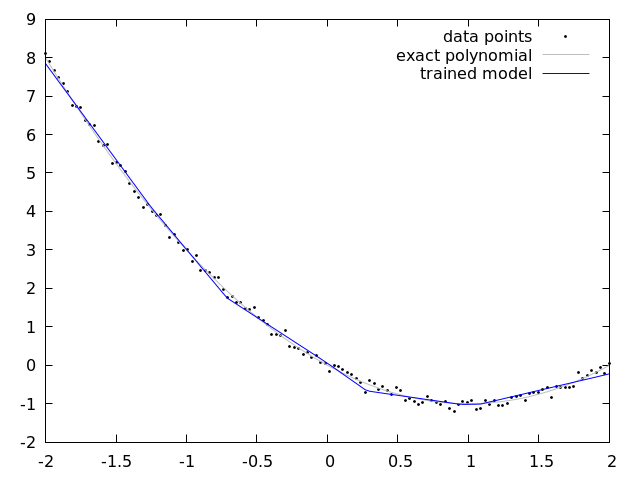

In [169]:

# Can we do train the NN using the more primitive methods like using pullback functions (# See the first example of linear regression )
# i.e., we don't want to use the Lux.Training API
# YES -- BE MINDFUL OF GLOBAL VARIABLES!!
# you can play with Adam or StochasticDescent with different learning rates 
rng = MersenneTwister()
Random.seed!(rng, 12345)
(x, y) = generate_data(rng)

model = Chain(Dense(1 => 16, relu), Dense(16 => 1)) # a single layer, 16 neurons, relu by default
ps, st = Lux.setup(rng, model)

# set up the optimizer to use stochastic gradient descent
# opt = Optimisers.Descent(0.01f0) # learning rate is 0.01
# opt = OptimizationOptimisers.Adam(0.03f0) # this works better
opt = Optimisers.Descent(0.05f0) # learning rate is 0.01
opt_state = Optimisers.setup(opt, ps) # initialize the state -- I don't know what this is doing.
println("opt_state: ", opt_state)

function loss_function(model, ps, st, data)
    y_pred, st = Lux.apply(model, data[1], ps, st)
    mse_loss = mean(abs2, y_pred .- data[2])
    return mse_loss, st, ()
end
# create a helper function
_loss(ps, data) = loss_function(model, ps, st, data)

# run a single epoch  
# the pullback function evaluates the loss function with the given inputs (the loss function itself returns a tuple)
# but also returns a function that can be used to (left) multiply a vector and jacobian (i.e., the vjp)
# gradient() is really just syntactic sugar around the more fundamental function pullback.
# In other words, the VJP is the jacobian if the left vector is just ones -- returns the corresponding column of the jacobian
(loss, st), pb_f = Zygote.pullback(_loss, ps, (x, y)) 
println("loss (initial epoch): ", loss) # would be large because NN weights/biases are far off 
println("state of the NN: ", st) 

# use the pullback function to get the gradient 
# not sure why a tuple (one(loss), nothing) is required as an input to the pullback function
# so this evaluates the derivative of the loss function at the x_samples and y_samples
gs = pb_f((one(loss), nothing))[1]  # the first element is the weights/biases -- and the second element is the derivative evaluated at the point?

# Update model parameters
# `Optimisers.update` can be used if mutation is not desired
opt_state, ps = Optimisers.update!(opt_state, ps, gs)
println("loss (after 1 epoc): ", _loss(ps, (x, y))[1]) # would be large because NN weights/biases are far off 
println("running 1000 epochs")
flush(stdout)
@showprogress dt=0.01 desc="Computing..." for i in 1:1000
    # In actual code, don't use globals. But here I will simply for the sake of demonstration
    global ps, st, opt_state 
    # Compute the gradient using the pullback API to update the states
    # the pullback evaluates the loss-function at the specified points (the first returned tuple)
    # the second tuple is the pullback function 
    (loss, st), pb_f = Zygote.pullback(_loss, ps, (x, y))
    # We pass nothing as the seed for `st`, since we don't want to propagate any gradient
    # for st
    gs = pb_f((one(loss), nothing))[1]
    # Update model parameters
    # `Optimisers.update` can be used if mutation is not desired
    opt_state, ps = Optimisers.update!(opt_state, ps, gs)
    # (i % 10 == 1 || i == 100) && println(lazy"Loss Value after $i iterations: $loss")
end
println("loss (after 1000 epochs): ", _loss(ps, (x, y))[1]) # would be large because NN weights/biases are far off 
y_pred_trained = Lux.apply(model, x, ps, st)[1] # returns a tuple of values and model state
@gp "reset" 
@gp :- x y "with points title 'data points' pt 7 ps 0.3 lc 'black'"
@gp :- x evalpoly.(x, ((0, -2, 1),)) "with lines title 'exact polynomial' lw 1 lc 'gray'"
@gp :- x y_pred_trained "with lines title 'trained model' lw 1 lc 'blue'"
